# Iris Classification

## Iris Versicolor

<img src="IRIS_VERSICOLOR.jpeg">

## Table of Contents
- [Objective](#obj)
- [Feature Distributions + Scatter Plots](#eda1)
- [Exploring Correlated Features](#eda2)
- [Pre-Processing](#pre)
- [Training Models](#train)
    - [K Nearest Neighbors](#knn)
    - [Random Forest](#rf)
    - [Gradient Boosting](#gb)

<a id='obj'></a>
## Objective
- Explore the dataset to find distinguishing features between iris species
- Perform dimensionality reduction techniques to explore the importance of all features
- Create a model that predicts iris species with flower features

### Data Description
- Flower species
    - Iris Setosa
    - Iris Versicolor
    - Iris Virginica
    
- Flower features
    - Petal length
    - Petal width
    - Sepal length
    - Sepal width

### Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

### Load Data

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = pd.read_csv(url, names=names)

### Data Quality Check

In [4]:
# shape
print("Shape: ",dataset.shape,"\n")

Shape:  (150, 5) 



In [5]:
# head
print("First records of data:\n ",dataset.head(),"\n")

First records of data:
     sepal-length  sepal-width  petal-length  petal-width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa 



In [6]:
# class distribution
print(dataset.groupby('class').size())

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


In [7]:
# Describe data frame
dataset.describe()

,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


From the initial quality check, we observe a balanced data set with 150 flower inputs.  The distribution of the data set is concentrated with small standard deviation for the features sepal-length, sepal-width, and petal-width. Petal-length seems to have more variability. Let us explore the feature distributions.

<a id='eda1'></a>
## EDA 1: Feature Distributions + Scatter Plots

From the initial pairplot, we have learned Iris-setosa has distinct features compared to iris-versicolor and iris-virginica. Some features also seem to be correlated.

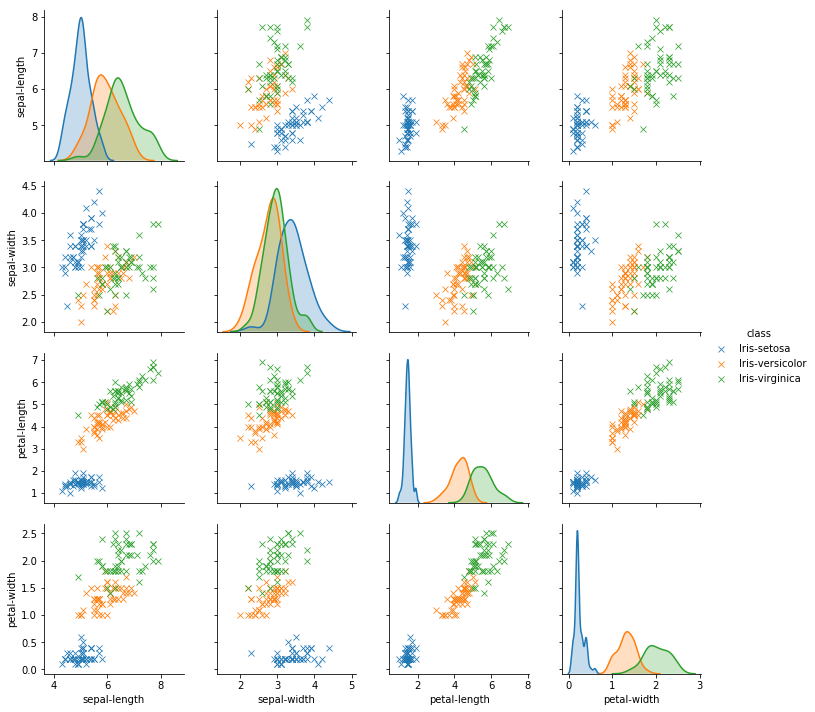

In [8]:
sns.pairplot(dataset, hue='class', markers='x')

We can visualize the distributions of features using a violin plot to better compare.

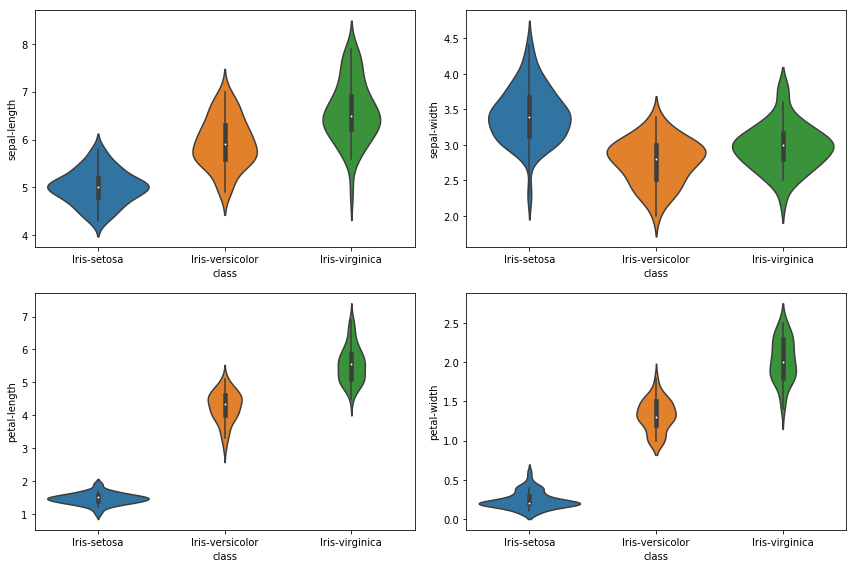

In [9]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

for idx, rows in enumerate(axes.flat):
    sns.violinplot(x = "class", y=dataset.columns[idx], data=dataset, ax=rows)
    f.tight_layout()

<a id='eda2'></a>
## EDA 2: Exploring Correlated Features

Most of these features are correlated, which begs the question if these features are necessary. Can we reduce dimensionality to more accurately predict the correct iris?

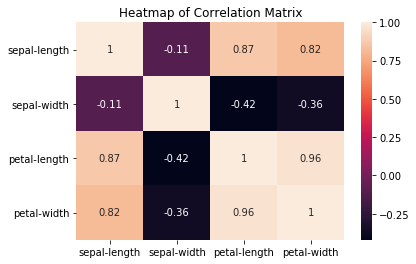

In [10]:
corr = dataset.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True)
plt.title('Heatmap of Correlation Matrix');

### PCA

The correlation matrix above suggested the importance of each feature. Thus, we can use PCA to hopefully reduce noise and better visualization. 

If we are to have two primary components, we observe these two components explain 95.7 of the variance. Thus, it'll be interesting to fit the model to the actual data vs these two primary components to compare the predictive power. 

On top of the variance explanation, we also see a better line separating versicolor and virginica 

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
X = dataset[names[:-1]]
X_scaled = StandardScaler().fit_transform(X)

In [13]:
pca= PCA(n_components=2)
pcomponents = pca.fit_transform(X_scaled)
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

In [14]:
dataset['class'] = pd.Categorical(dataset['class'])
dataset['code'] = dataset['class'].cat.codes

In [15]:
PC_df = pd.DataFrame(pcomponents,columns=['PC1','PC2'])
PC_df['code'] = dataset['code']
PC_df['class'] = dataset['class']

Text(0, 0.5, 'Second principle component')

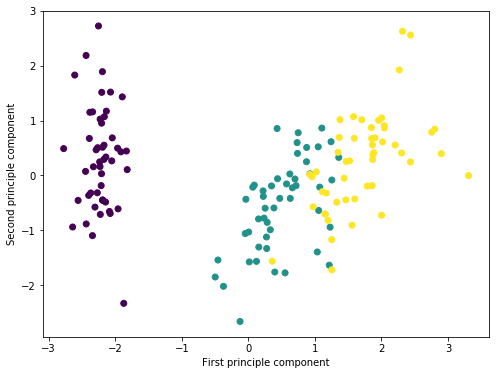

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(PC_df['PC1'],PC_df['PC2'], c=PC_df['code'])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

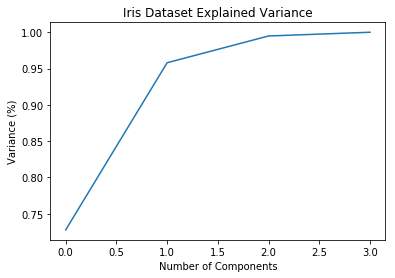

In [17]:
#Fitting the PCA algorithm with our Data
pca2 = PCA().fit(X_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Iris Dataset Explained Variance')
plt.show()

## EDA on PCs

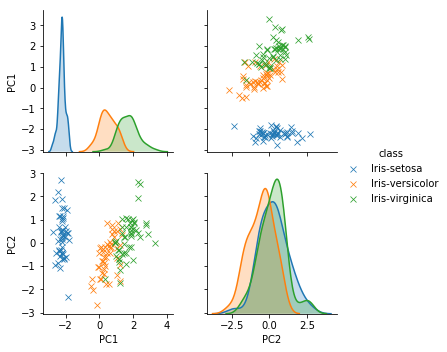

In [18]:
sns.pairplot(PC_df, hue='class', markers='x',vars=['PC1','PC2'])

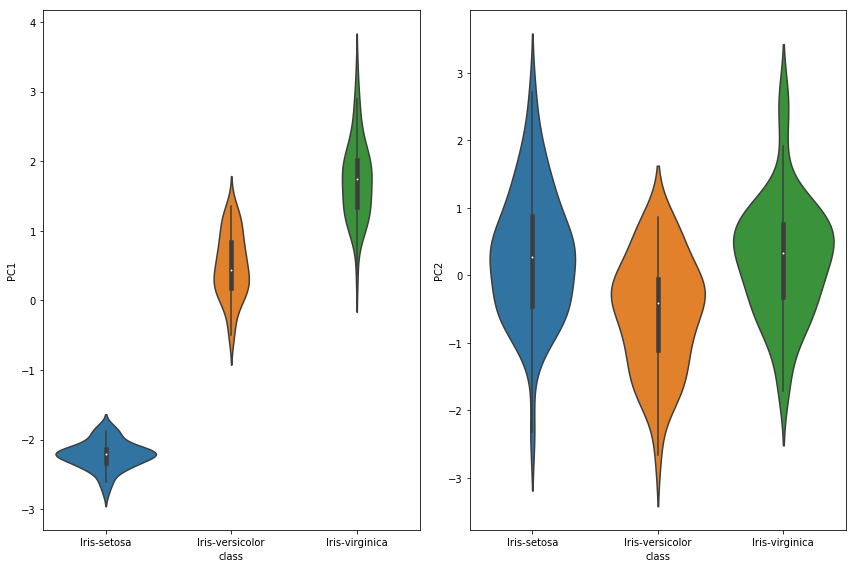

In [19]:
f, axes = plt.subplots(ncols=2, figsize=(12,8))

for idx, rows in enumerate(axes.flat):
    sns.violinplot(x = "class", y=PC_df.columns[idx], data=PC_df, ax=rows)
    f.tight_layout()

From the Primary component analysis, we have clearly separated Setosa from versicolor and virginica in PC1. Although this is true, there is overlap between the 3 species in PC2.

If we wanted to interpret the principle components, we could interpret PC1 as the petal dimensions and PC2 as the sepal dimensions.

<a id='pre'></a>
## Pre-Processing

We need to separate the data with train_test_split to obtain train/test data to train and fit our model.

We will also be scaling our data with StandardScaler

In [108]:
X

,sepal-length,sepal-width,petal-length,petal-width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [115]:
from sklearn.model_selection import train_test_split 

X = dataset[names[:-1]]
X_scaled = StandardScaler().fit_transform(X)
y = dataset['code']
# Scaled data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)
# PC data
X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(pcomponents,y,test_size=0.20, random_state=123)

In [117]:
y.shape

(150,)

<a id='train'></a>
## Training Models
1. Logistic Regression
2. K-Nearesst Neighbor
2. SVM
3. Random Forest
4. Gradient Boosting Classifier

From the initial model fit, we can see that more features does give a better fit. Having correlated features does not matter for a better fit in this particular case.


In [29]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [103]:
from sklearn.model_selection import cross_validate

In [203]:
# Test options and evaluation metric 
seed = 7
scoring = 'accuracy'

results = []
results_pc = []

names_mla = []

# evaluate each model in turn
for name, model in models:
    kfo = model_selection.KFold(n_splits=5,random_state=1234)
    cv_results = cross_validate(model, 
                                X_train, 
                                y_train, 
                                cv=kfo, 
                                scoring=scoring)
    cv_results_pc = cross_validate(model, 
                                X_train_pc, 
                                y_train_pc, 
                                cv=kfo, 
                                scoring=scoring)
    results.append([cv_results['train_score'].mean(),
                    cv_results['test_score'].mean()])
    results_pc.append([cv_results_pc['train_score'].mean(),
                       cv_results_pc['test_score'].mean()])

    names_mla.append(name)
    msg = "%s: %f , %f  (%f, %f)" % (name, 
                                     cv_results['train_score'].mean(), 
                                     cv_results['test_score'].mean(), 
                                     cv_results['train_score'].std(),
                                     cv_results['test_score'].std())
    msg_pc = "%s: %f , %f  (%f, %f)" % (name, 
                                     cv_results_pc['train_score'].mean(), 
                                     cv_results_pc['test_score'].mean(), 
                                     cv_results_pc['train_score'].std(),
                                     cv_results_pc['test_score'].std())
    print('--------Original Features, PC------')
    print(msg)
    print(msg_pc)

--------Original Features, PC------
LR: 0.962500 , 0.950000  (0.008333, 0.031180)
LR: 0.860417 , 0.841667  (0.015590, 0.061237)
--------Original Features, PC------
KNN: 0.983333 , 0.975000  (0.008333, 0.050000)
KNN: 0.943750 , 0.916667  (0.026842, 0.045644)
--------Original Features, PC------
SVM: 0.985417 , 0.966667  (0.008333, 0.048591)
SVM: 0.941667 , 0.925000  (0.014130, 0.040825)
--------Original Features, PC------
RF: 1.000000 , 0.925000  (0.000000, 0.048591)
RF: 0.995833 , 0.916667  (0.005103, 0.026352)
--------Original Features, PC------
GB: 1.000000 , 0.925000  (0.000000, 0.048591)
GB: 1.000000 , 0.916667  (0.000000, 0.026352)


From the first sweep, we can that the PCs do a great job in fitting the model. But we can't conclude much due to a small data set. Can we include additional features to get a better fit, ie adding area and join PCs and original data?

## Feature Engineering

In [85]:
dataset['sepal-area'] =  dataset['sepal-length']*dataset['sepal-width']
dataset['petal-area'] =  dataset['petal-length']*dataset['petal-width']
dataset['PC1'] = pcomponents[:,0]
dataset['PC2'] = pcomponents[:,1]

Using these new features, can we do a better job at classifying iris flowers?
First, we check the fit with the addition of the area and then with the primary components.

In [97]:
from sklearn.model_selection import train_test_split 

cols_area = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'sepal-area', 'petal-area']
cols_area_pc = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'sepal-area', 'petal-area', 'PC1', 'PC2']

X_area = dataset[cols_area]
X_area_pc = dataset[cols_area_pc]

X_scaled_area = StandardScaler().fit_transform(X_area)
X_scaled_area_pc = StandardScaler().fit_transform(X_area_pc)
y = dataset['code']
# Scaled data
#Area
X_train_area, X_test_area, y_train_area, y_test_area = train_test_split(X_scaled_area,y,test_size=0.20, random_state=123)
# Area + PC
X_train_area_pc, X_test_area_pc, y_train_area_pc, y_test_area_pc = train_test_split(X_scaled_area_pc,y,test_size=0.20, random_state=123)

In [205]:
# Test options and evaluation metric 
scoring = 'accuracy'

results = []
results_pc = []
results_area = []
results_area_pc = []
names_mla = []

# evaluate each model in turn
print('       Train,   Validation    (Std Train, Std Test)  ')
for name, model in models:
    kfo = model_selection.KFold(n_splits=10,random_state=1234)
    cv_results_area = cross_validate(model, 
                                X_train_area, 
                                y_train_area, 
                                cv=kfo, 
                                scoring=scoring)
    cv_results_area_pc = cross_validate(model, 
                                X_train_area_pc, 
                                y_train_area_pc, 
                                cv=kfo, 
                                scoring=scoring)
    results_area.append([cv_results_area['train_score'].mean(),
                         cv_results_area['test_score'].mean()])
    results_area_pc.append([cv_results_area_pc['train_score'].mean(),
                            cv_results_area_pc['test_score'].mean()])

    names_mla.append(name)
    msg_area = "%s : %f , %f  (%f, %f) (Original+Area)" % (name, 
                                    cv_results_area['train_score'].mean(), 
                                     cv_results_area['test_score'].mean(), 
                                     cv_results_area['train_score'].std(),
                                     cv_results_area['test_score'].std())
    msg_area_pc = "%s : %f , %f  (%f, %f) (Original+Area+PC)" % (name, 
                                        cv_results_area_pc['train_score'].mean(), 
                                        cv_results_area_pc['test_score'].mean(), 
                                        cv_results_area_pc['train_score'].std(),
                                        cv_results_area_pc['test_score'].std())
    
    print(msg_area)
    print(msg_area_pc)

       Train,   Validation    (Std Train, Std Test)  
LR : 0.948148 , 0.941667  (0.006142, 0.053359) (Original+Area)
LR : 0.949074 , 0.941667  (0.007465, 0.053359) (Original+Area+PC)
KNN : 0.966667 , 0.950000  (0.007407, 0.055277) (Original+Area)
KNN : 0.966667 , 0.958333  (0.007407, 0.055902) (Original+Area+PC)
SVM : 0.989815 , 0.958333  (0.004986, 0.055902) (Original+Area)
SVM : 0.982407 , 0.950000  (0.009667, 0.055277) (Original+Area+PC)
RF : 0.992593 , 0.933333  (0.006929, 0.097183) (Original+Area)
RF : 0.999074 , 0.933333  (0.002778, 0.097183) (Original+Area+PC)
GB : 1.000000 , 0.933333  (0.000000, 0.097183) (Original+Area)
GB : 1.000000 , 0.933333  (0.000000, 0.097183) (Original+Area+PC)


From this analysis, we can conclude that adding additional features does not help the fit by much. Thus, we will continue the hyperparameter tuning with just the original data. 

<a id='knn'></a>
## K Nearest Neighbor

In [210]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=10)
knn_cv.fit(X_train, y_train);
print('Best Parameter K: ', knn_cv.best_params_)

Best Parameter K:  {'n_neighbors': 9}


#### KNN Fitted Model Prediction

We can observe the optimal K from GridSearchCV is 3 and in doing so we obtain 100 percent accuracy for the validation set. We also obtain 96.67% accuracy for the test set with only 1 classified incorrectly.

Again, we seem to be missing some information with the PCs, suggesting although the >90% of the variance can be explained with 2 features, the other 2 features add information

In [211]:
knn = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)
print('Train Accuracy Score: ', knn.score(X_train,y_train))
print('Test Accuracy Score: ', knn.score(X_test,y_test))

Train Accuracy Score:  0.975
Test Accuracy Score:  0.9666666666666667


In [212]:
print('Train Data Confusion Matrix:')
print(confusion_matrix(y_train, knn.predict(X_train)))
print('Test Data Confusion Matrix:')
print(confusion_matrix(y_test, knn.predict(X_test)))

Train Data Confusion Matrix:
[[37  0  0]
 [ 0 43  1]
 [ 0  2 37]]
Test Data Confusion Matrix:
[[13  0  0]
 [ 0  6  0]
 [ 0  1 10]]


<a id='rf'></a>
## Random Forest

In [230]:
param_grid = {'n_estimators':[1, 2, 3, 4, 5, 15, 20, 25, 40, 50, 70, 100]}
rf = RandomForestClassifier()
kfo = model_selection.KFold(n_splits=10,random_state=1234)
rf_cv = GridSearchCV(rf, param_grid, cv=kfo)
rf_cv.fit(X_train, y_train);

In [231]:
print('Best Parameter n_estimators: ', rf_cv.best_params_)

Best Parameter n_estimators:  {'n_estimators': 3}


In [242]:
rf = RandomForestClassifier(n_estimators=3, random_state=1).fit(X_train, y_train)
print('Train Accuracy Score: ', rf.score(X_train,y_train))
print('Test Accuracy Score: ', rf.score(X_test,y_test))

Train Accuracy Score:  0.9916666666666667
Test Accuracy Score:  0.9666666666666667


In [244]:
print('Train Data Confusion Matrix:')
print(confusion_matrix(y_train, rf.predict(X_train)))
print('Test Data Confusion Matrix:')
print(confusion_matrix(y_test, rf.predict(X_test)))

Train Data Confusion Matrix:
[[37  0  0]
 [ 0 43  1]
 [ 0  0 39]]
Test Data Confusion Matrix:
[[13  0  0]
 [ 0  5  1]
 [ 0  0 11]]


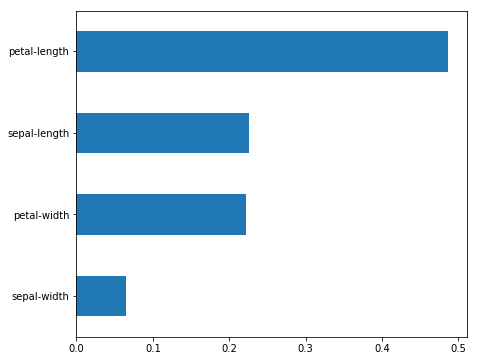

In [245]:
feature_importances = pd.Series(rf.feature_importances_, index=dataset.columns[:4])
#print(feature_importances)
feature_importances.sort_values(inplace=True);
feature_importances.plot(kind='barh', figsize=(7,6));

Using random forest, we can observe the importance of each feature. Not to our surprise, the petal width and length are the most importan features of the dataset to identify the flower.

<a id='gb'></a>
## GradientBoosting

In [246]:
param_grid = {'n_estimators':np.arange(1,50)}
gb = GradientBoostingClassifier()
kfo = model_selection.KFold(n_splits=10,random_state=1234)
gb_cv = GridSearchCV(gb, param_grid, cv=kfo)
gb_cv.fit(X_train, y_train);
print('Best Parameter n_estimators: ', gb_cv.best_params_)

Best Parameter n_estimators:  {'n_estimators': 3}


In [248]:
gb = GradientBoostingClassifier(n_estimators=3, random_state=1).fit(X_train, y_train)
print('Train Accuracy Score: ', gb.score(X_train,y_train))
print('Test Accuracy Score: ', gb.score(X_test,y_test))

Train Accuracy Score:  1.0
Test Accuracy Score:  0.9666666666666667


In [250]:
print('Train Data Confusion Matrix:')
print(confusion_matrix(y_train, gb.predict(X_train)))
print('Test Data Confusion Matrix:')
print(confusion_matrix(y_test, gb.predict(X_test)))

Train Data Confusion Matrix:
[[37  0  0]
 [ 0 44  0]
 [ 0  0 39]]
Test Data Confusion Matrix:
[[13  0  0]
 [ 0  6  0]
 [ 0  1 10]]


## Conclusions

Our analysis contained 150 flowers and their sepal width and length and petal width and length. From the exploratory data analysis, we saw a large overlap in 2 flower types (versicolor and virginica) and a large correlation between flower features. Using primary component analysis, we were able to explain 95.7% of the variance.

From our model, we are able to achieve 100% train accuracy and 96.7 test accuracy. The misclassification comes from versicolor and virginica, which is consistent to the EDA. Using feature engineering, we tried to include the PCs or using the area of the features but not much changed in the accuracy when using cross validation.

From the analysis, we were able to create a high accuracy model with only a small dataset. The misclassification, if any, will come from versicolor and virginica due to their similar features. In order to find distinguishing features, we would need to get a bigger data set or additional feature engineering. 